### **1. Import the libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
! pip install segmentation_models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random
!pip install split-folders
import splitfolders

Segmentation Models: using `tf.keras` framework.


### **2. Data Preprocessing**

In [ ]:
seed=24
batch_size= 32
n_classes=2

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

#Preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
def preprocess_data(img, mask, num_class):
    # Scale images
    scaler = MinMaxScaler()
    img_flat = img.reshape(-1, img.shape[-1])
    img_scaled = scaler.fit_transform(img_flat).reshape(img.shape)
    img_processed = preprocess_input(img_scaled)  # Preprocess based on the pretrained backbone...

    # Ensure mask values are within the range [0, num_classes-1]
    mask = np.clip(mask, 0, num_class - 1)

    # Convert mask to one-hot
    mask_one_hot = to_categorical(mask, num_class)

    return img_processed, mask_one_hot

### **3. Train set and Valid set Loader**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):

    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)



In [ ]:
train_img_path = "/content/drive/MyDrive/Covid_Dataset/train_images/"
train_mask_path = "/content/drive/MyDrive/Covid_Dataset/train_masks/"


val_img_path = "/content/drive/MyDrive/Covid_Dataset/val_images/"
val_mask_path = "/content/drive/MyDrive/Covid_Dataset/val_masks/"

test_img_path = '/content/drive/MyDrive/Covid_Dataset/test_images'
test_mask_path = '/content/drive/MyDrive/Covid_Dataset/test_masks'


In [ ]:
# Create generators
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=n_classes)
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes)
test_img_gen = trainGenerator(test_img_path, test_mask_path, num_class=n_classes)
x, y = train_img_gen.__next__()


Found 1864 images belonging to 1 classes.
Found 1864 images belonging to 1 classes.


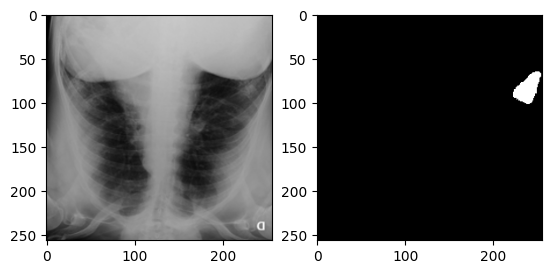

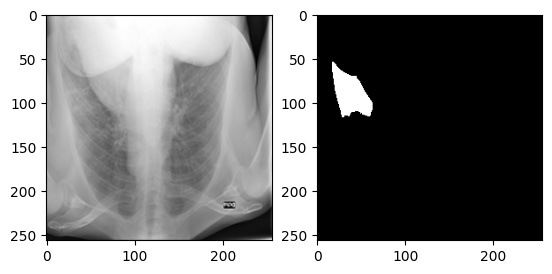

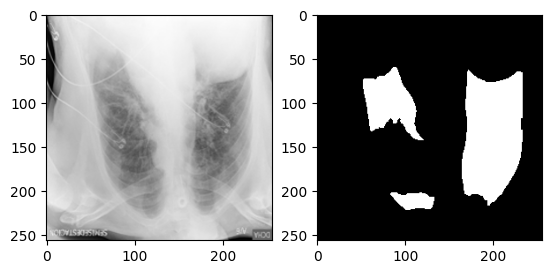

Found 466 images belonging to 1 classes.
Found 466 images belonging to 1 classes.


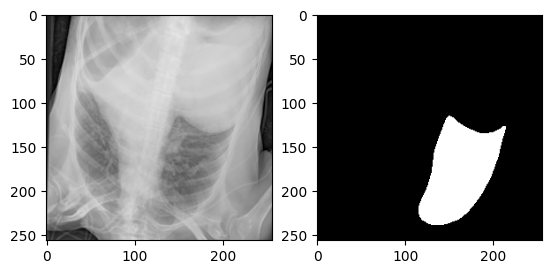

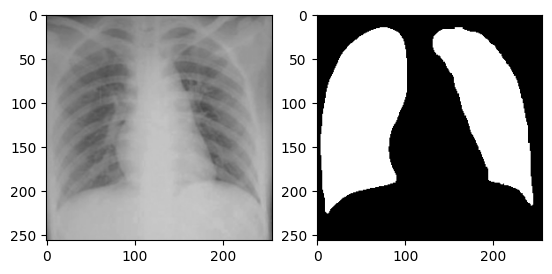

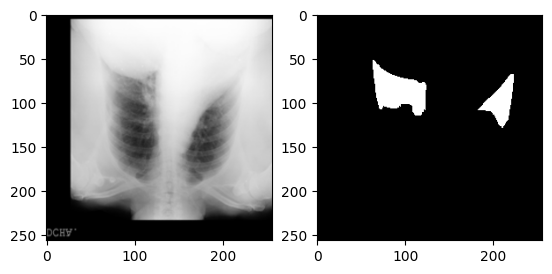

In [ ]:
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)

    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

### **4. Unet Model Training**

In [ ]:
num_train_imgs = len(os.listdir('/content/drive/MyDrive/Covid_Dataset/train_images/train/'))
num_val_images = len(os.listdir('/content/drive/MyDrive/Covid_Dataset/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=2

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/drive/MyDrive/covid_model_weights.h5"

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             mode='min',
                             verbose=1)

In [ ]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet',
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [ ]:
print(model.summary())
print(model.input_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 256, 256, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

In [ ]:
from keras.models import load_model
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
history = model.fit(train_img_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    verbose=1,
                    validation_data=val_img_gen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[checkpoint])


Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 0.3500 - iou_score: 0.6710
Epoch 1: val_loss improved from inf to 0.68736, saving model to /content/drive/MyDrive/covid_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 74s 925ms/step - loss: 0.3500 - iou_score: 0.6710 - val_loss: 0.6874 - val_iou_score: 0.4202
Epoch 2/50
58/58 [==============================] - ETA: 0s - loss: 0.2529 - iou_score: 0.7733
Epoch 2: val_loss improved from 0.68736 to 0.66496, saving model to /content/drive/MyDrive/covid_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 51s 889ms/step - loss: 0.2529 - iou_score: 0.7733 - val_loss: 0.6650 - val_iou_score: 0.4314
Epoch 3/50
58/58 [==============================] - ETA: 0s - loss: 0.2491 - iou_score: 0.7759
Epoch 3: val_loss did not improve from 0.66496
58/58 [==============================] - 43s 738ms/step - loss: 0.2491 - iou_score: 0.7759 - val_loss: 0.7029 - val_iou_score: 0.4298
Epoch 4/50
58/58 [==============================] - ETA: 0s - loss: 0.2390 - iou_score: 0.7860
Epoch 4: val_loss did not improve from 0.66496
58/58 [==============================] - 43s 738ms/step - loss: 0.2390 - iou_score: 0.7860 - val_loss: 0.6674 - val_iou_score: 0.4418
Epoch 5/50
58/58 [==============================] - ETA: 0s - loss: 0.2415 - iou_score: 0.7851
Epoch 5: val_loss did not improve from 0.66496
58/58 [==============================] - 43s 751ms/step - loss: 0.2415 - iou_score: 0.7851 - val_loss: 0.7074 - val_iou_score: 0.4285
Epoch 6/50
58/58 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 45s 775ms/step - loss: 0.2215 - iou_score: 0.8042 - val_loss: 0.6544 - val_iou_score: 0.4418
Epoch 9/50
58/58 [==============================] - ETA: 0s - loss: 0.2228 - iou_score: 0.8018
Epoch 9: val_loss improved from 0.65438 to 0.55497, saving model to /content/drive/MyDrive/covid_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 45s 775ms/step - loss: 0.2228 - iou_score: 0.8018 - val_loss: 0.5550 - val_iou_score: 0.5344
Epoch 10/50
58/58 [==============================] - ETA: 0s - loss: 0.2099 - iou_score: 0.8117
Epoch 10: val_loss improved from 0.55497 to 0.53954, saving model to /content/drive/MyDrive/covid_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 50s 875ms/step - loss: 0.2099 - iou_score: 0.8117 - val_loss: 0.5395 - val_iou_score: 0.5479
Epoch 11/50
58/58 [==============================] - ETA: 0s - loss: 0.2232 - iou_score: 0.8015
Epoch 11: val_loss improved from 0.53954 to 0.49515, saving model to /content/drive/MyDrive/covid_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 51s 881ms/step - loss: 0.2232 - iou_score: 0.8015 - val_loss: 0.4951 - val_iou_score: 0.5847
Epoch 12/50
58/58 [==============================] - ETA: 0s - loss: 0.2057 - iou_score: 0.8166
Epoch 12: val_loss improved from 0.49515 to 0.43093, saving model to /content/drive/MyDrive/covid_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 50s 873ms/step - loss: 0.2057 - iou_score: 0.8166 - val_loss: 0.4309 - val_iou_score: 0.6396
Epoch 13/50
58/58 [==============================] - ETA: 0s - loss: 0.2104 - iou_score: 0.8138
Epoch 13: val_loss did not improve from 0.43093
58/58 [==============================] - 42s 735ms/step - loss: 0.2104 - iou_score: 0.8138 - val_loss: 0.4747 - val_iou_score: 0.6048
Epoch 14/50
58/58 [==============================] - ETA: 0s - loss: 0.2047 - iou_score: 0.8177
Epoch 14: val_loss improved from 0.43093 to 0.38504, saving model to /content/drive/MyDrive/covid_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 46s 792ms/step - loss: 0.2047 - iou_score: 0.8177 - val_loss: 0.3850 - val_iou_score: 0.6882
Epoch 15/50
58/58 [==============================] - ETA: 0s - loss: 0.2005 - iou_score: 0.8221
Epoch 15: val_loss improved from 0.38504 to 0.32689, saving model to /content/drive/MyDrive/covid_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 46s 799ms/step - loss: 0.2005 - iou_score: 0.8221 - val_loss: 0.3269 - val_iou_score: 0.7268
Epoch 16/50
58/58 [==============================] - ETA: 0s - loss: 0.1993 - iou_score: 0.8238
Epoch 16: val_loss improved from 0.32689 to 0.31795, saving model to /content/drive/MyDrive/covid_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 46s 796ms/step - loss: 0.1993 - iou_score: 0.8238 - val_loss: 0.3179 - val_iou_score: 0.7283
Epoch 17/50
58/58 [==============================] - ETA: 0s - loss: 0.2056 - iou_score: 0.8177
Epoch 17: val_loss improved from 0.31795 to 0.30993, saving model to /content/drive/MyDrive/covid_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 46s 804ms/step - loss: 0.2056 - iou_score: 0.8177 - val_loss: 0.3099 - val_iou_score: 0.7444
Epoch 18/50
58/58 [==============================] - ETA: 0s - loss: 0.2005 - iou_score: 0.8230
Epoch 18: val_loss improved from 0.30993 to 0.29527, saving model to /content/drive/MyDrive/covid_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 48s 835ms/step - loss: 0.2005 - iou_score: 0.8230 - val_loss: 0.2953 - val_iou_score: 0.7560
Epoch 19/50
58/58 [==============================] - ETA: 0s - loss: 0.1950 - iou_score: 0.8273
Epoch 19: val_loss improved from 0.29527 to 0.26471, saving model to /content/drive/MyDrive/covid_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 48s 833ms/step - loss: 0.1950 - iou_score: 0.8273 - val_loss: 0.2647 - val_iou_score: 0.7743
Epoch 20/50
58/58 [==============================] - ETA: 0s - loss: 0.1983 - iou_score: 0.8246
Epoch 20: val_loss did not improve from 0.26471
58/58 [==============================] - 44s 761ms/step - loss: 0.1983 - iou_score: 0.8246 - val_loss: 0.2825 - val_iou_score: 0.7646
Epoch 21/50
58/58 [==============================] - ETA: 0s - loss: 0.1907 - iou_score: 0.8316
Epoch 21: val_loss did not improve from 0.26471
58/58 [==============================] - 42s 730ms/step - loss: 0.1907 - iou_score: 0.8316 - val_loss: 0.2930 - val_iou_score: 0.7631
Epoch 22/50
58/58 [==============================] - ETA: 0s - loss: 0.1917 - iou_score: 0.8298
Epoch 22: val_loss did not improve from 0.26471
58/58 [==============================] - 43s 747ms/step - loss: 0.1917 - iou_score: 0.8298 - val_loss: 0.3260 - val_iou_score: 0.7257
Epoch 23/50
58/58 [=============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 45s 780ms/step - loss: 0.1900 - iou_score: 0.8311 - val_loss: 0.2626 - val_iou_score: 0.7821
Epoch 25/50
58/58 [==============================] - ETA: 0s - loss: 0.1758 - iou_score: 0.8440
Epoch 25: val_loss did not improve from 0.26263
58/58 [==============================] - 45s 783ms/step - loss: 0.1758 - iou_score: 0.8440 - val_loss: 0.3038 - val_iou_score: 0.7504
Epoch 26/50
58/58 [==============================] - ETA: 0s - loss: 0.1880 - iou_score: 0.8334
Epoch 26: val_loss did not improve from 0.26263
58/58 [==============================] - 42s 728ms/step - loss: 0.1880 - iou_score: 0.8334 - val_loss: 0.2636 - val_iou_score: 0.7753
Epoch 27/50
58/58 [==============================] - ETA: 0s - loss: 0.1875 - iou_score: 0.8352
Epoch 27: val_loss did not improve from 0.26263
58/58 [==============================] - 44s 761ms/step - loss: 0.1875 - iou_score: 0.8352 - val_loss: 0.2823 - val_iou_score: 0.7713
Epoch 28/50
58/58 [=============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 47s 816ms/step - loss: 0.1825 - iou_score: 0.8387 - val_loss: 0.2527 - val_iou_score: 0.7894
Epoch 32/50
58/58 [==============================] - ETA: 0s - loss: 0.1700 - iou_score: 0.8488
Epoch 32: val_loss did not improve from 0.25270
58/58 [==============================] - 49s 858ms/step - loss: 0.1700 - iou_score: 0.8488 - val_loss: 0.3042 - val_iou_score: 0.7478
Epoch 33/50
58/58 [==============================] - ETA: 0s - loss: 0.1818 - iou_score: 0.8398
Epoch 33: val_loss did not improve from 0.25270
58/58 [==============================] - 47s 811ms/step - loss: 0.1818 - iou_score: 0.8398 - val_loss: 0.2928 - val_iou_score: 0.7621
Epoch 34/50
58/58 [==============================] - ETA: 0s - loss: 0.1801 - iou_score: 0.8408
Epoch 34: val_loss did not improve from 0.25270
58/58 [==============================] - 45s 776ms/step - loss: 0.1801 - iou_score: 0.8408 - val_loss: 0.3000 - val_iou_score: 0.7593
Epoch 35/50
58/58 [=============

In [ ]:
model.save('/content/drive/MyDrive/covid_batch16_2.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **5. Model Evaluation**

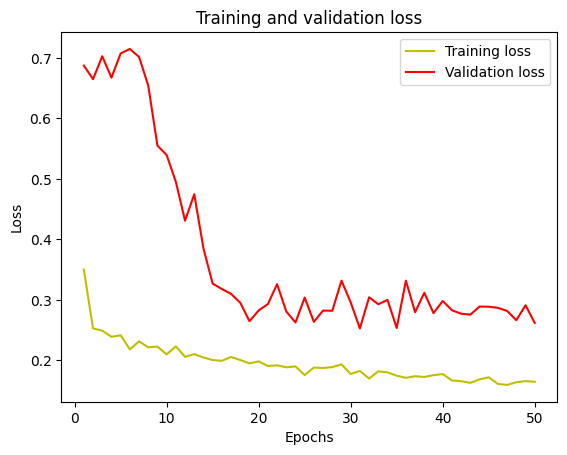

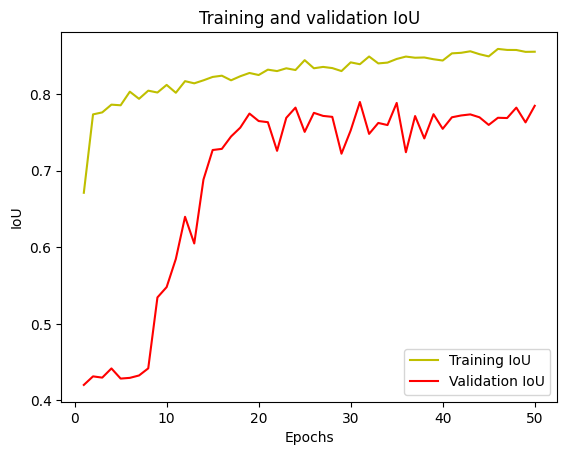

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

### **6. Prediction**

In [ ]:
from keras.models import load_model

model = load_model("/content/drive/MyDrive/covid_model_weights.h5", compile=False)


test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 1s 1s/step
Mean IoU = 0.80450153


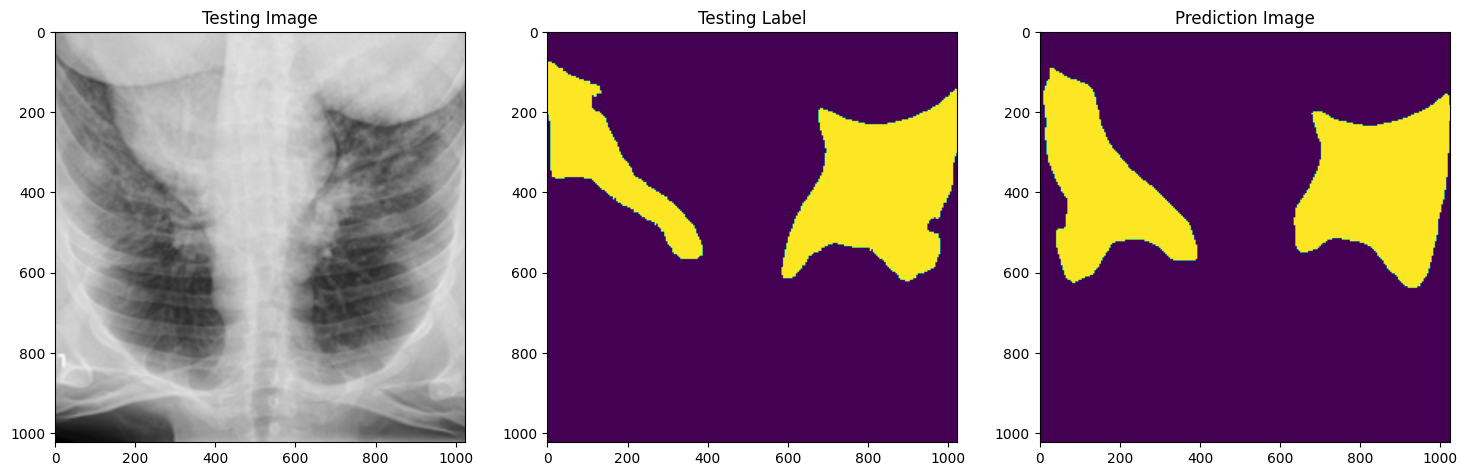

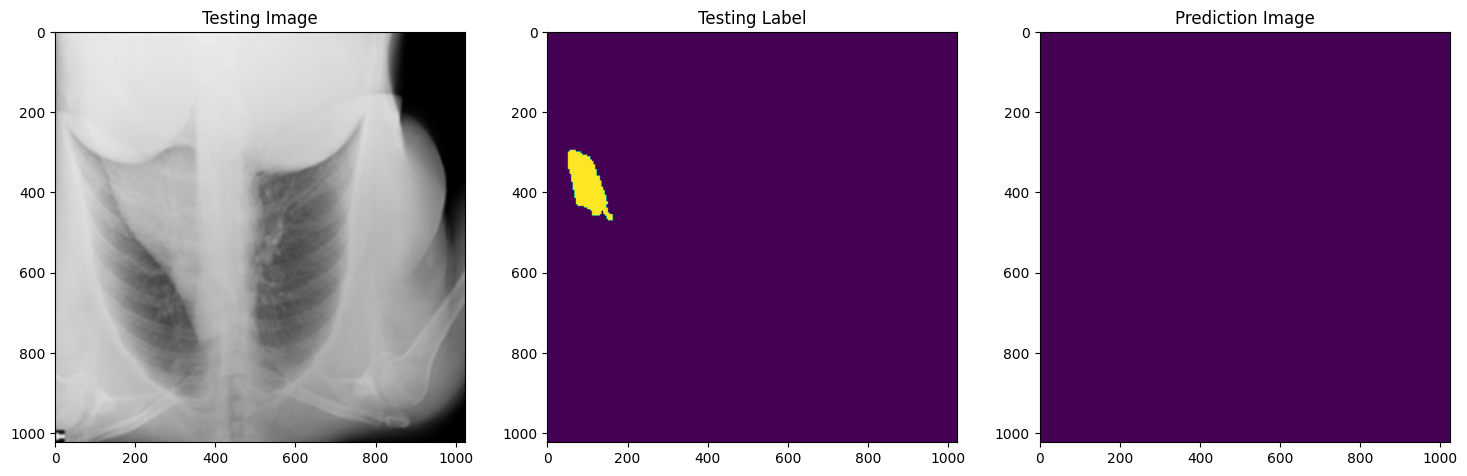

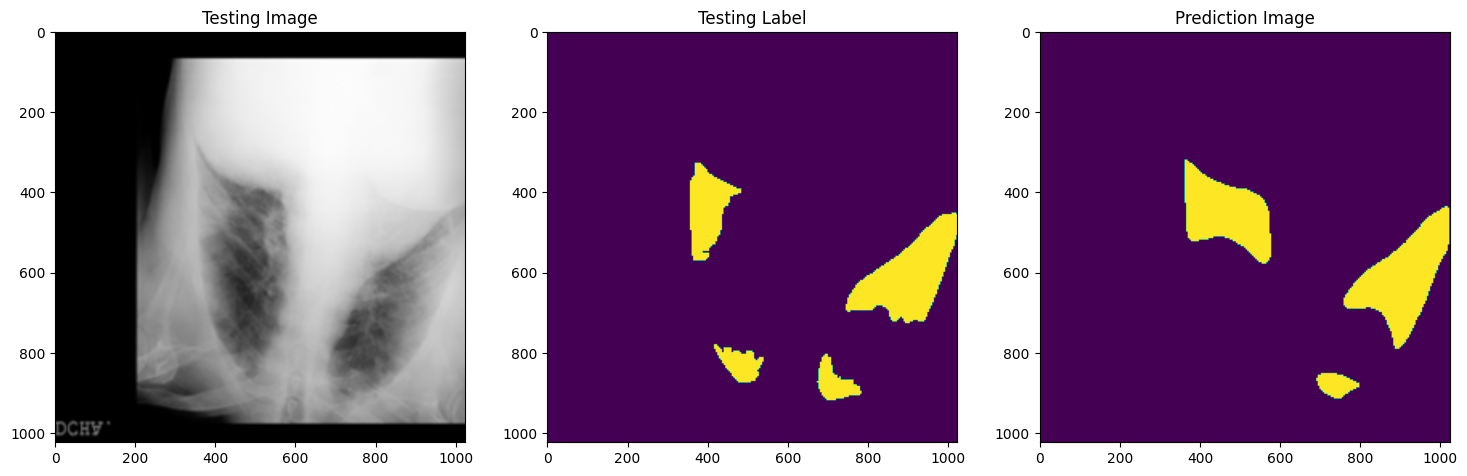

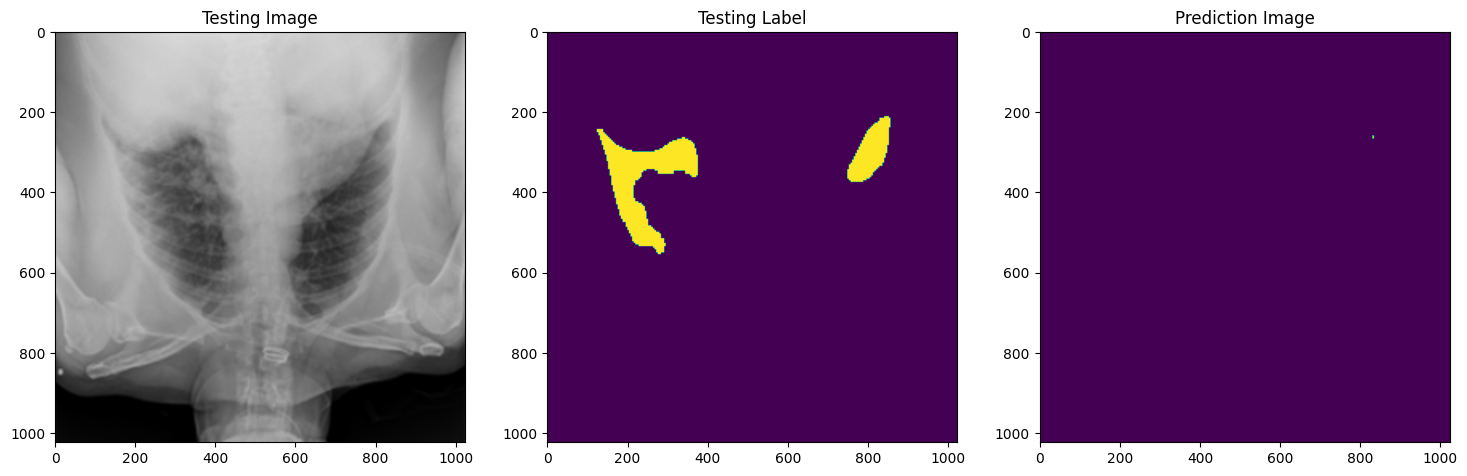

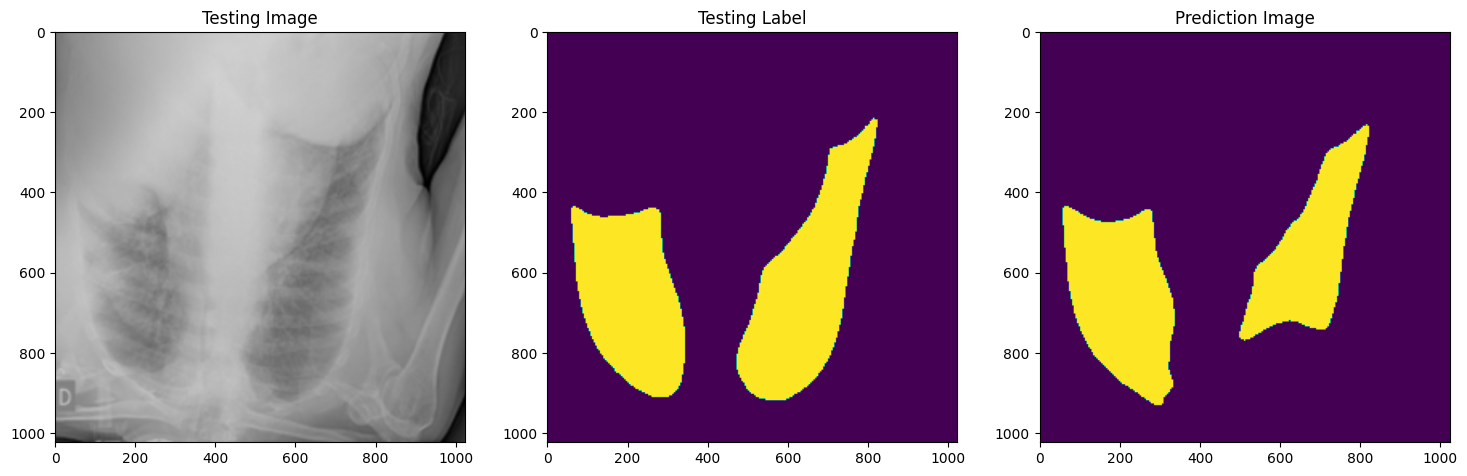

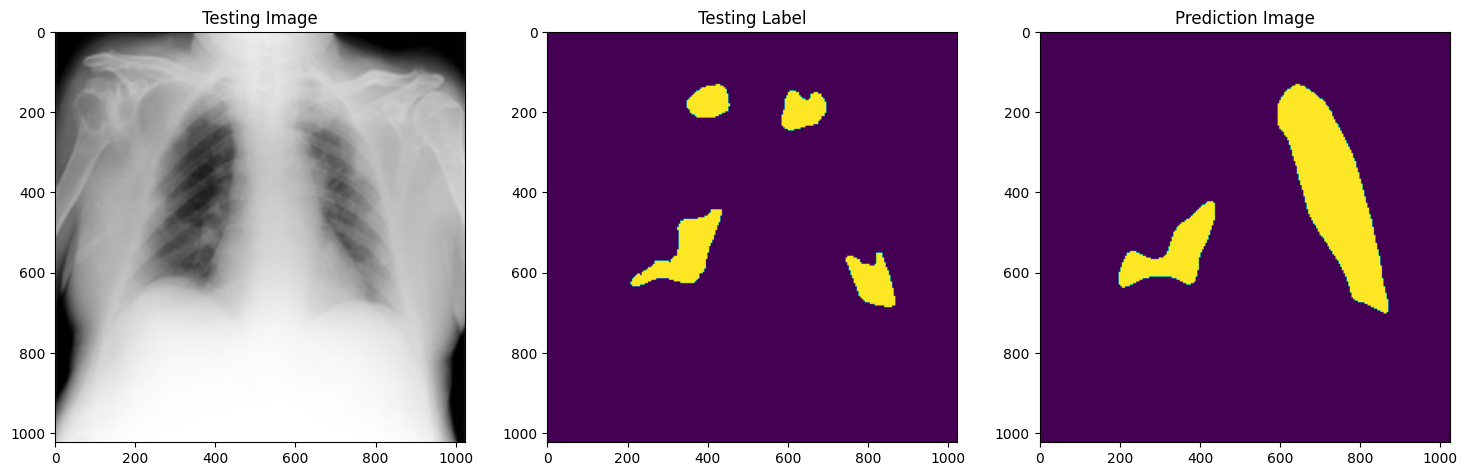

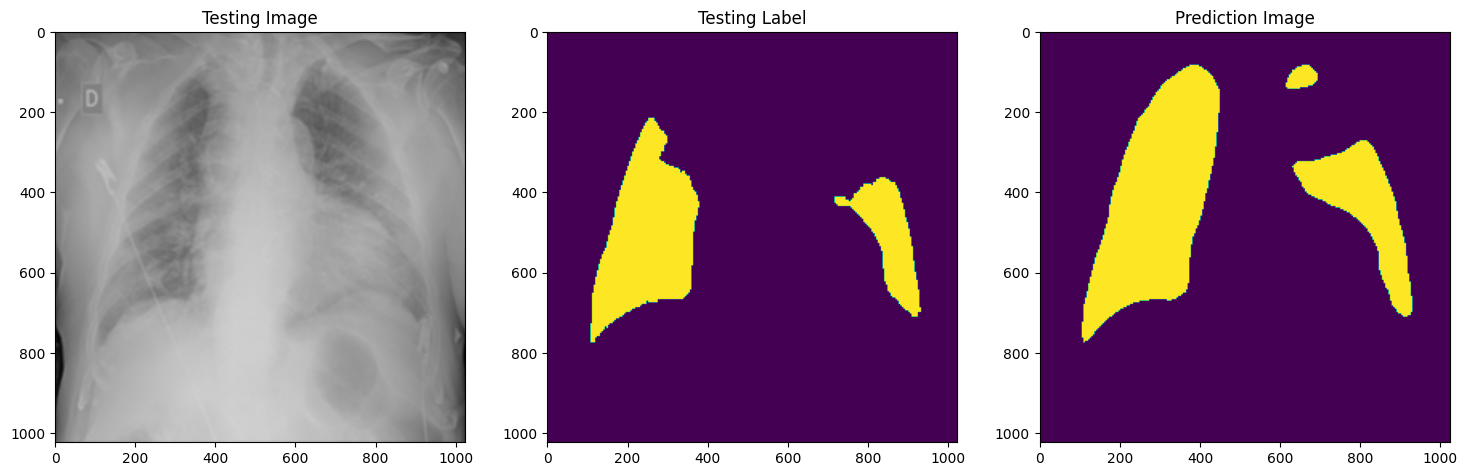

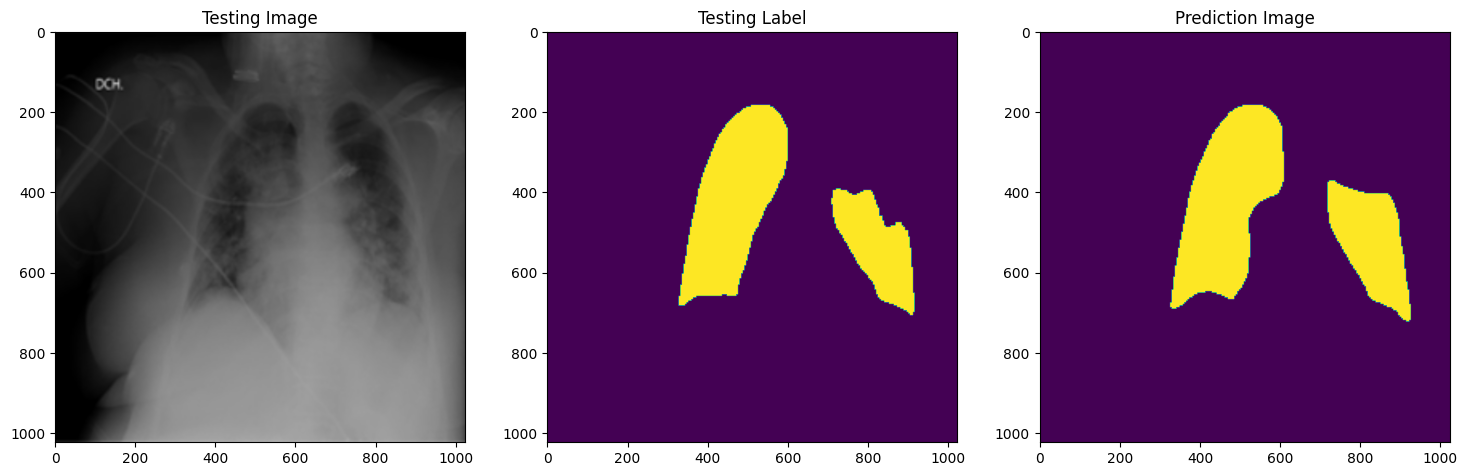

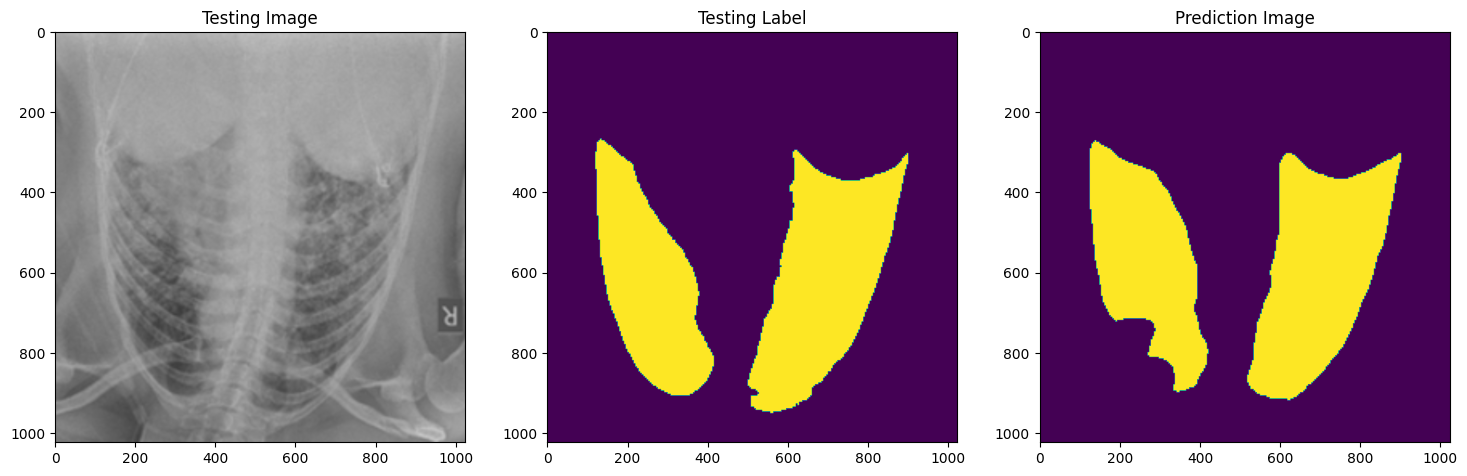

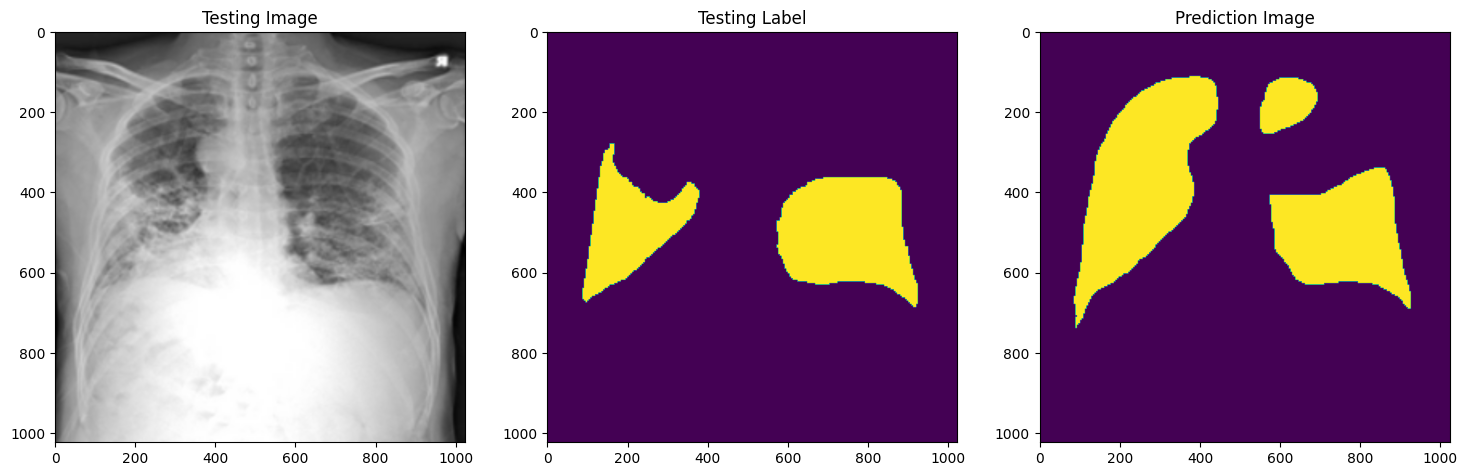

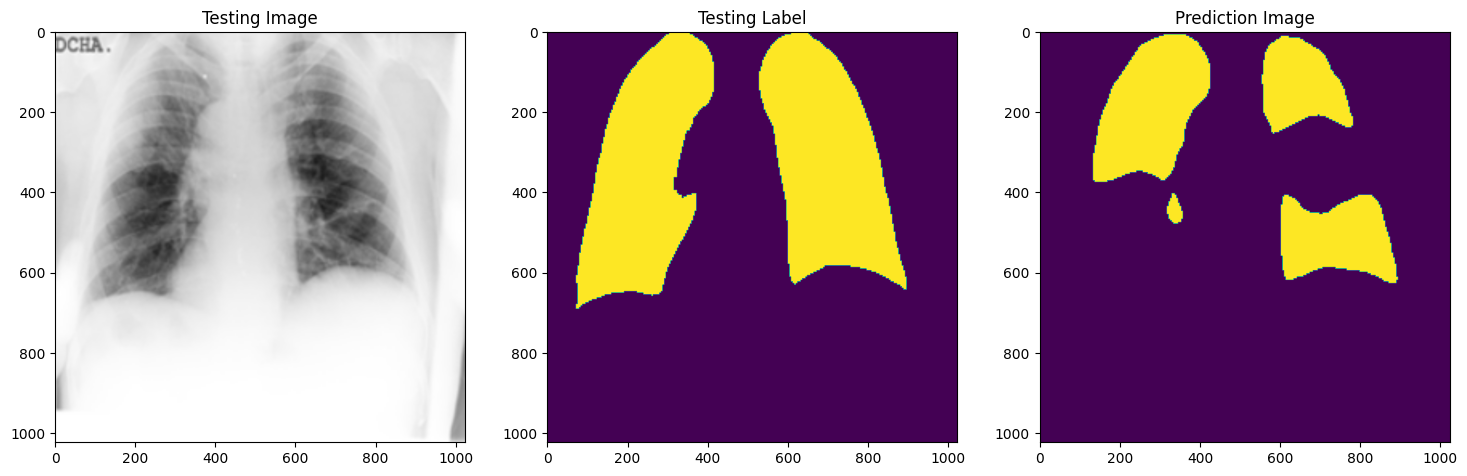

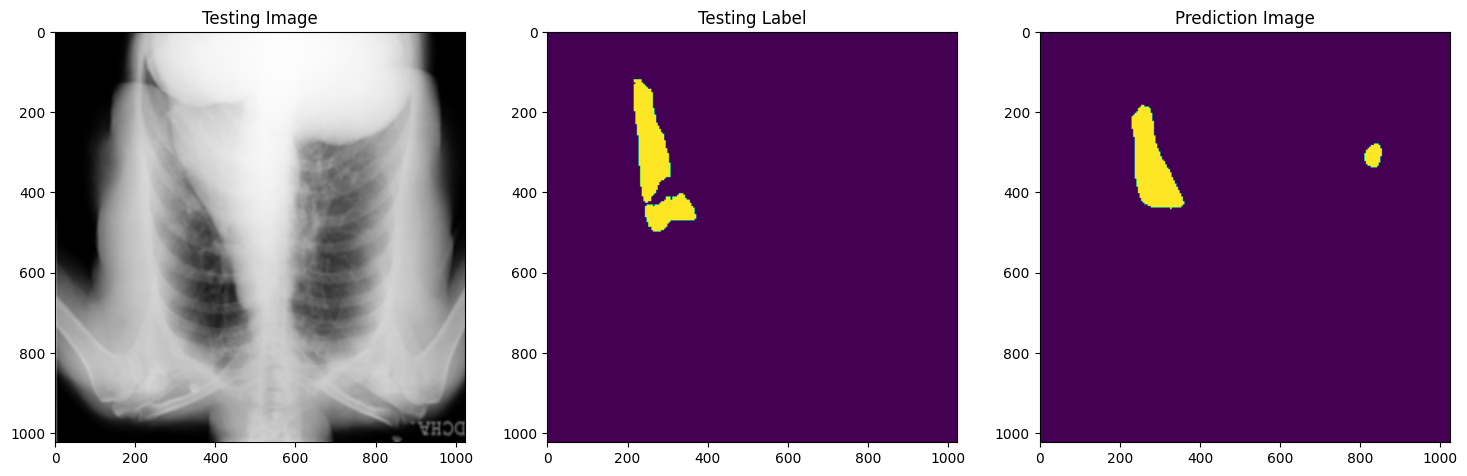

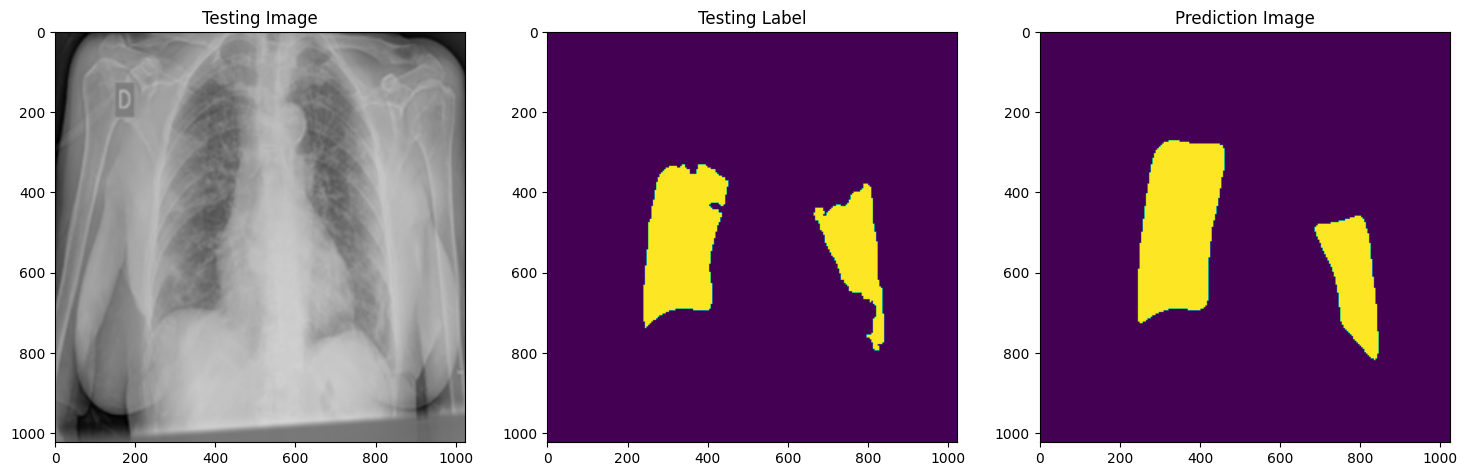

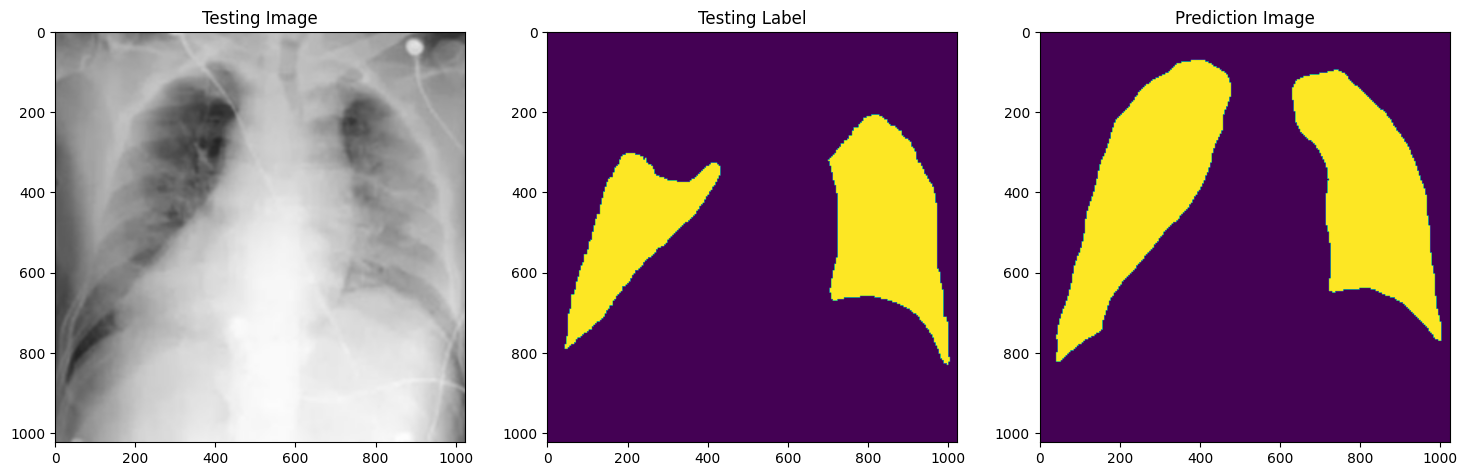

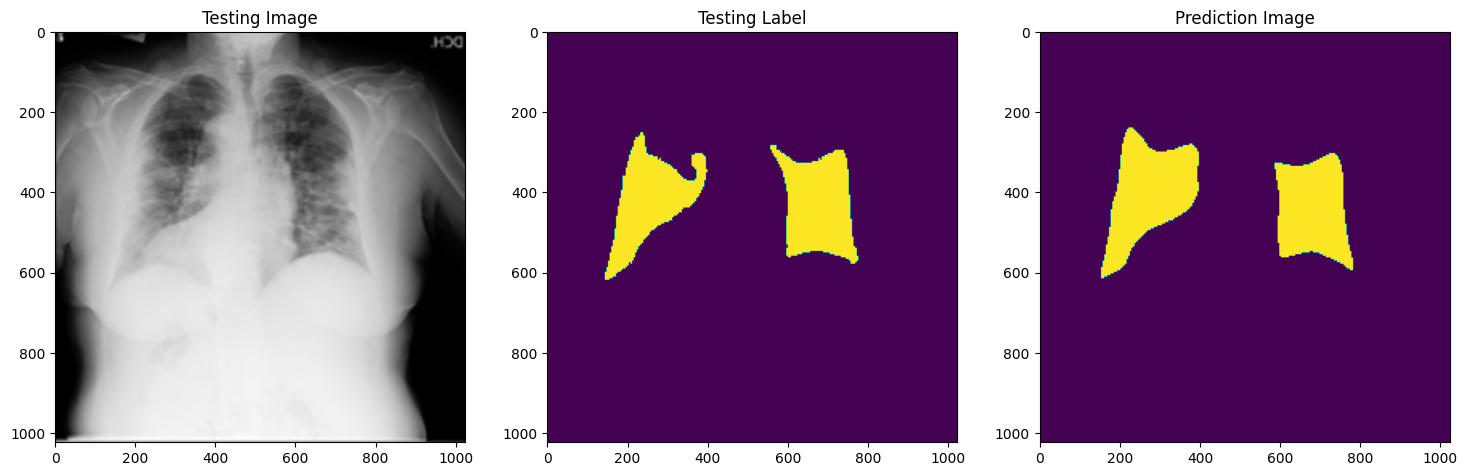

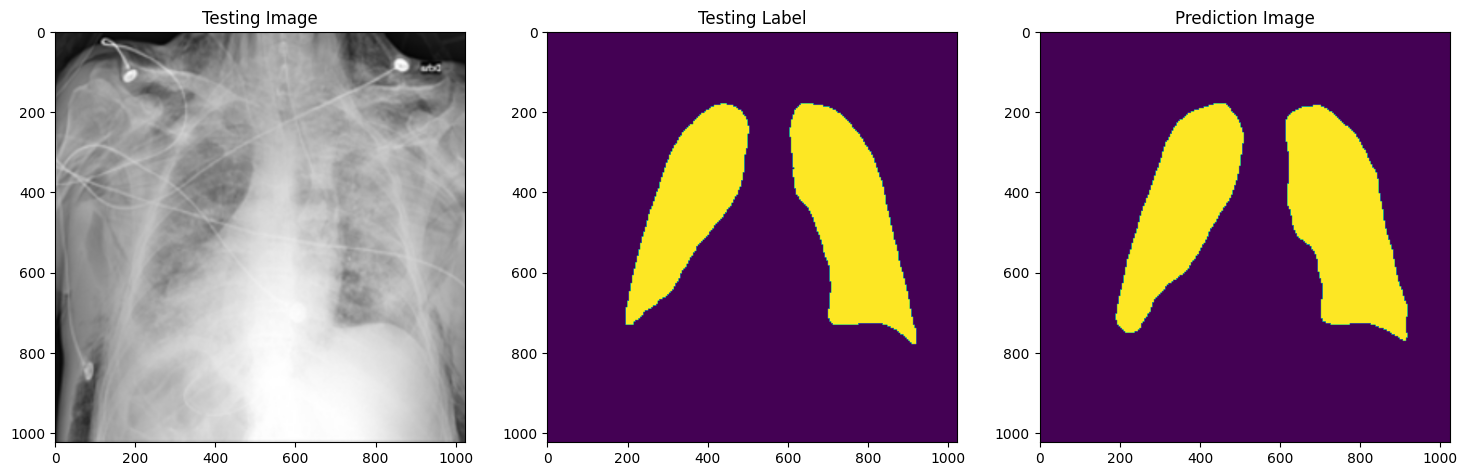

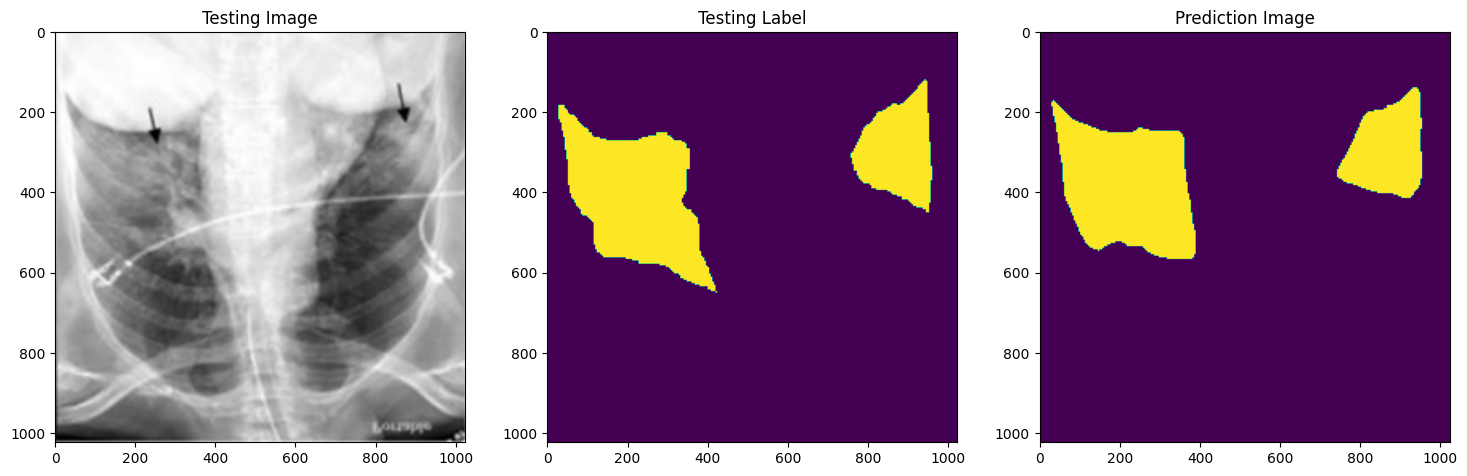

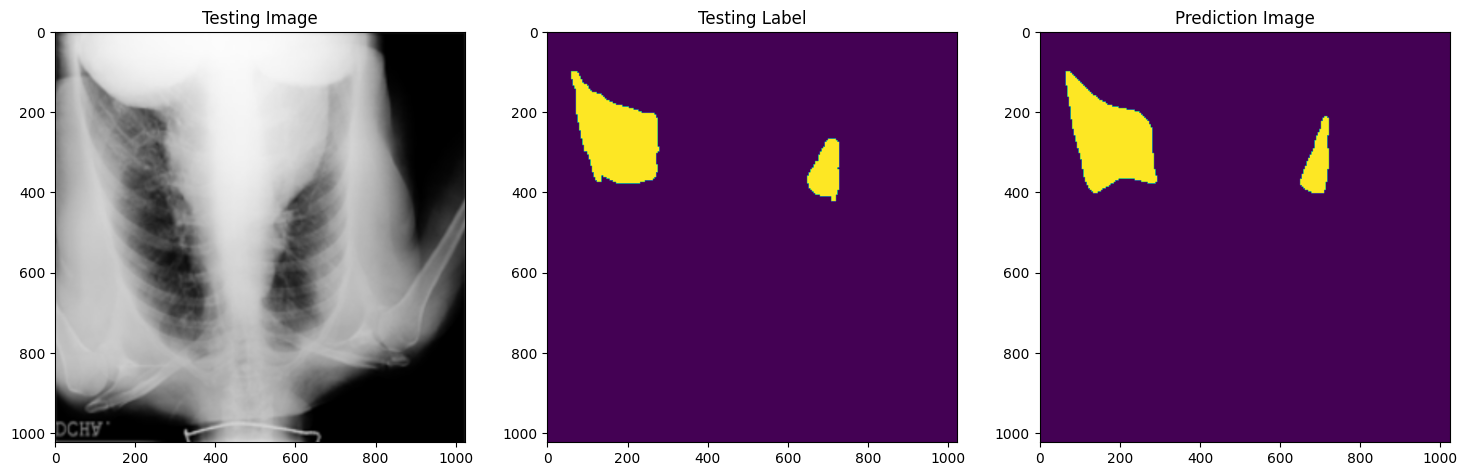

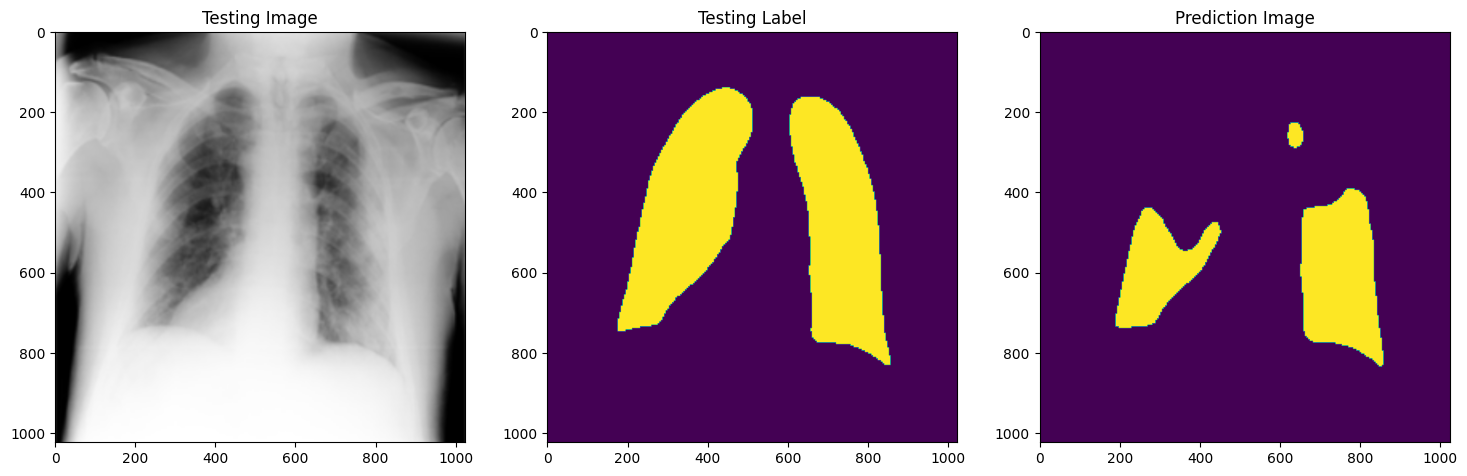

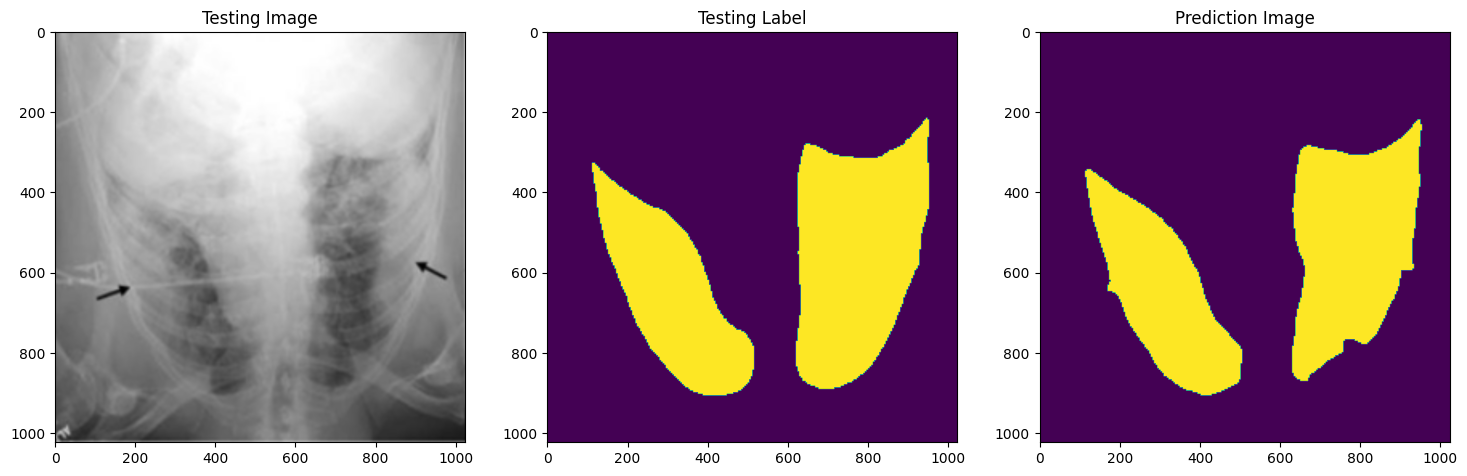

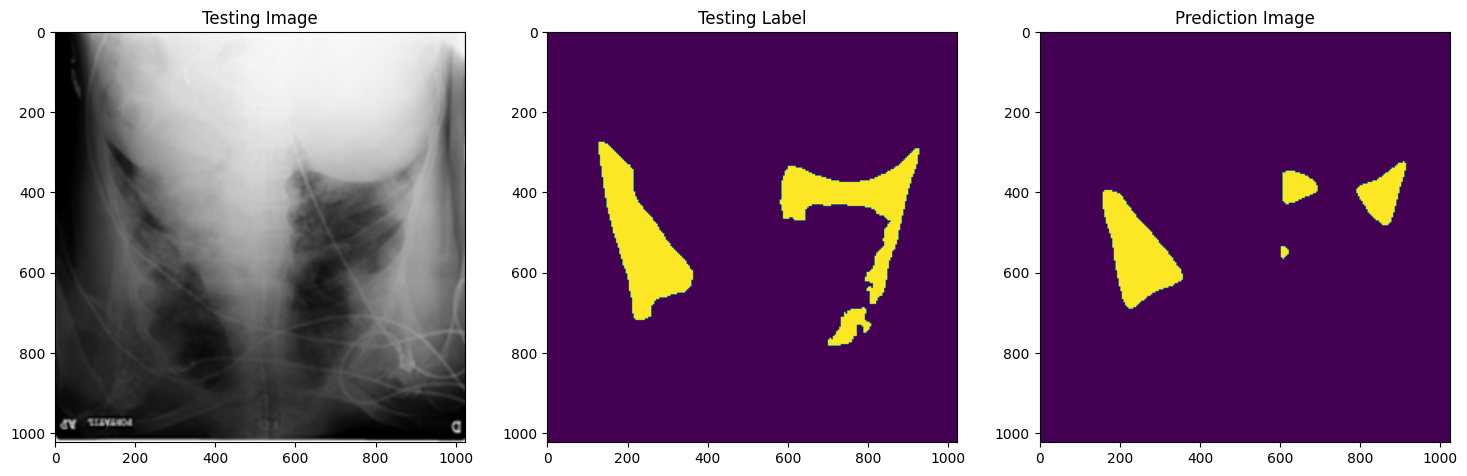

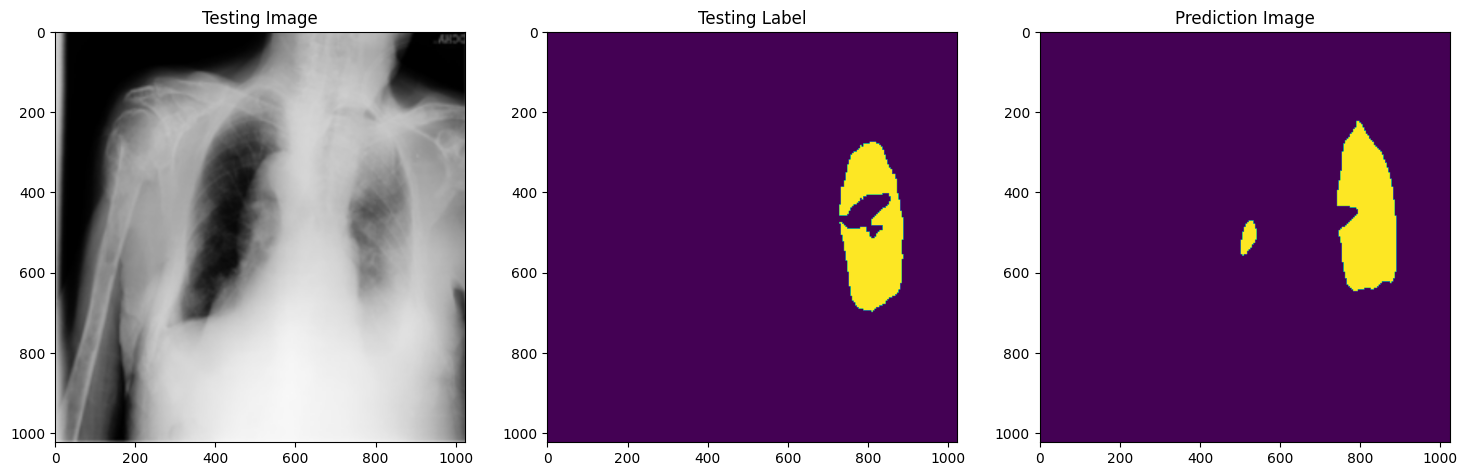

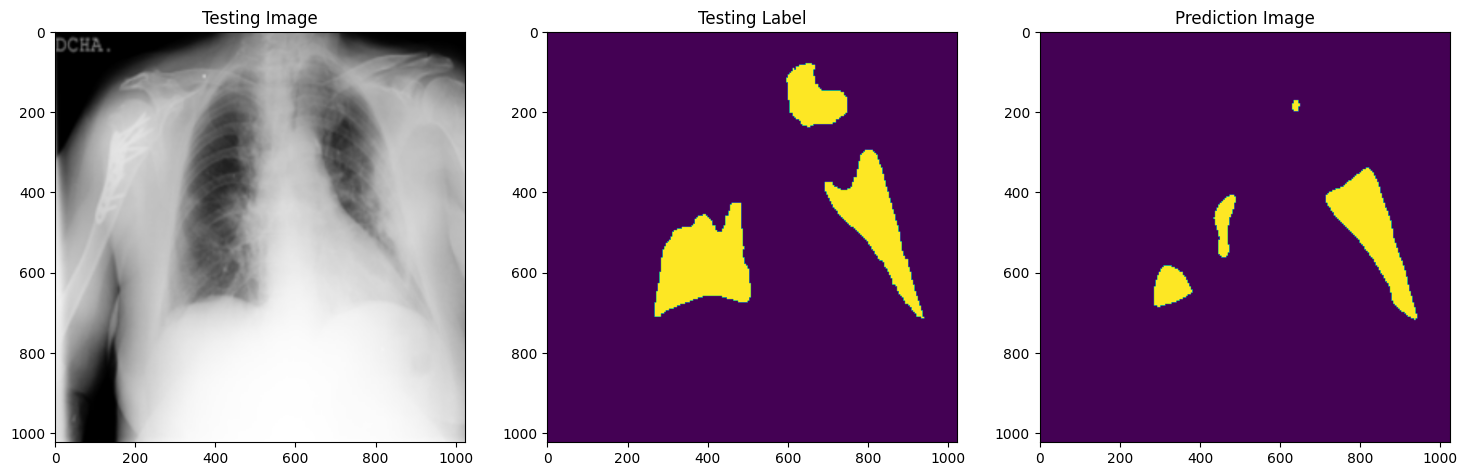

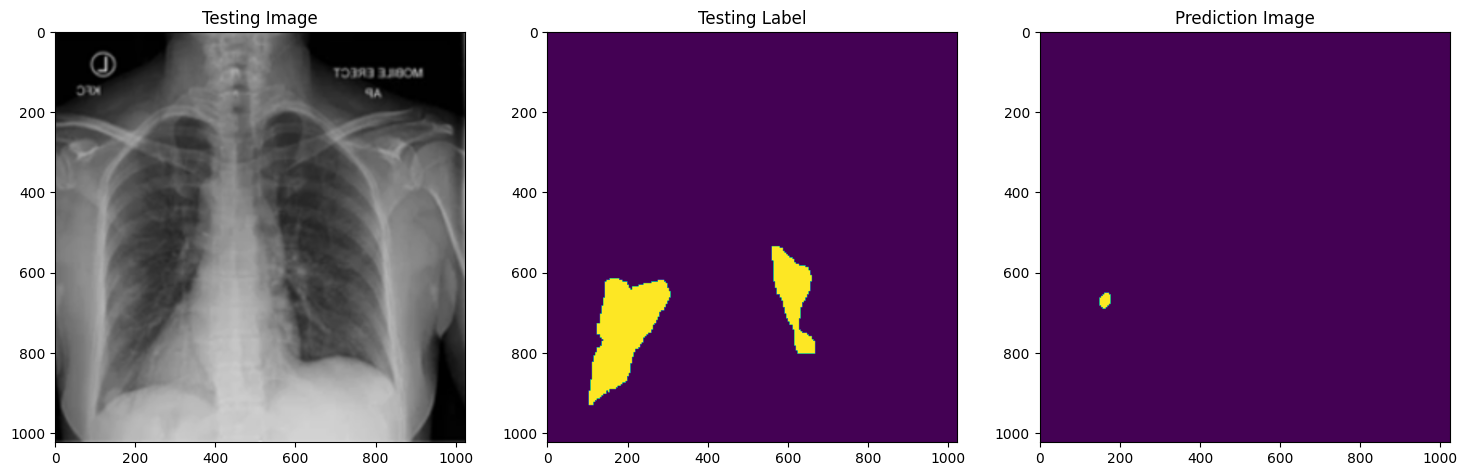

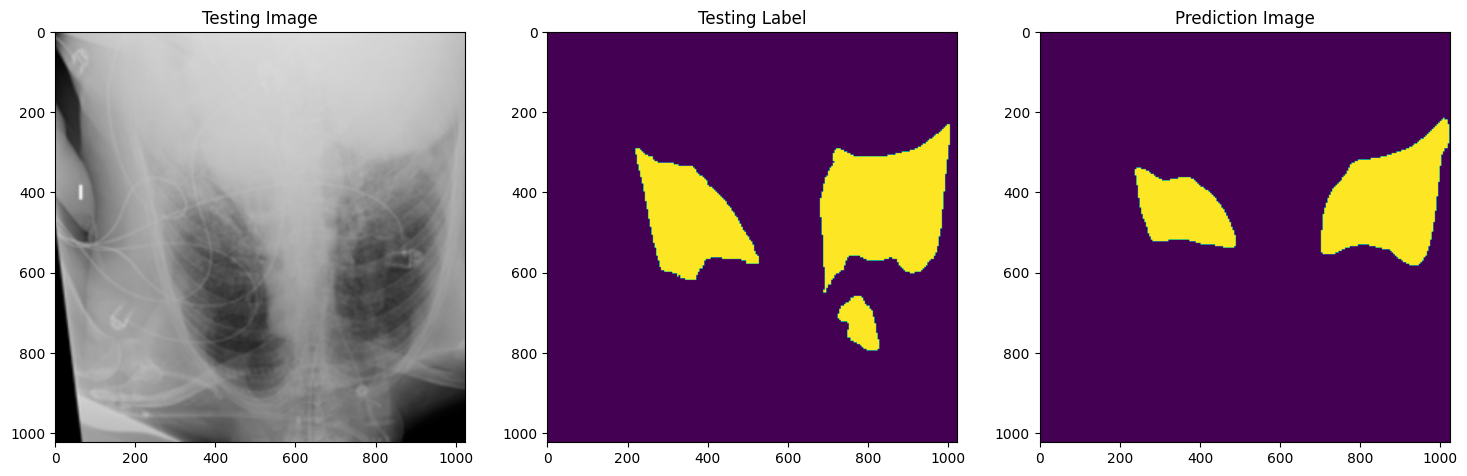

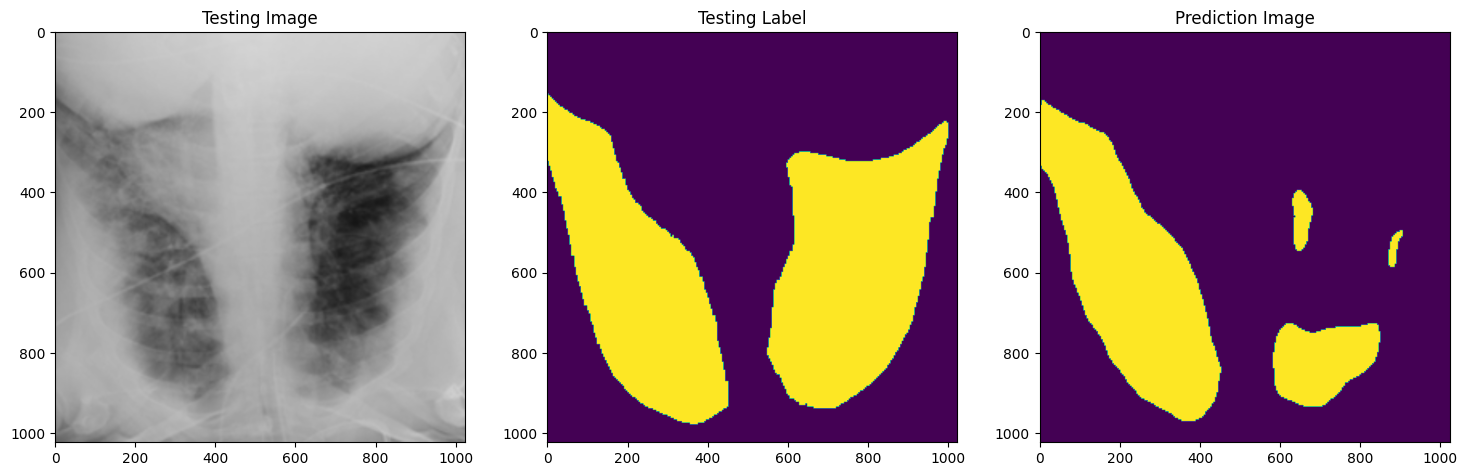

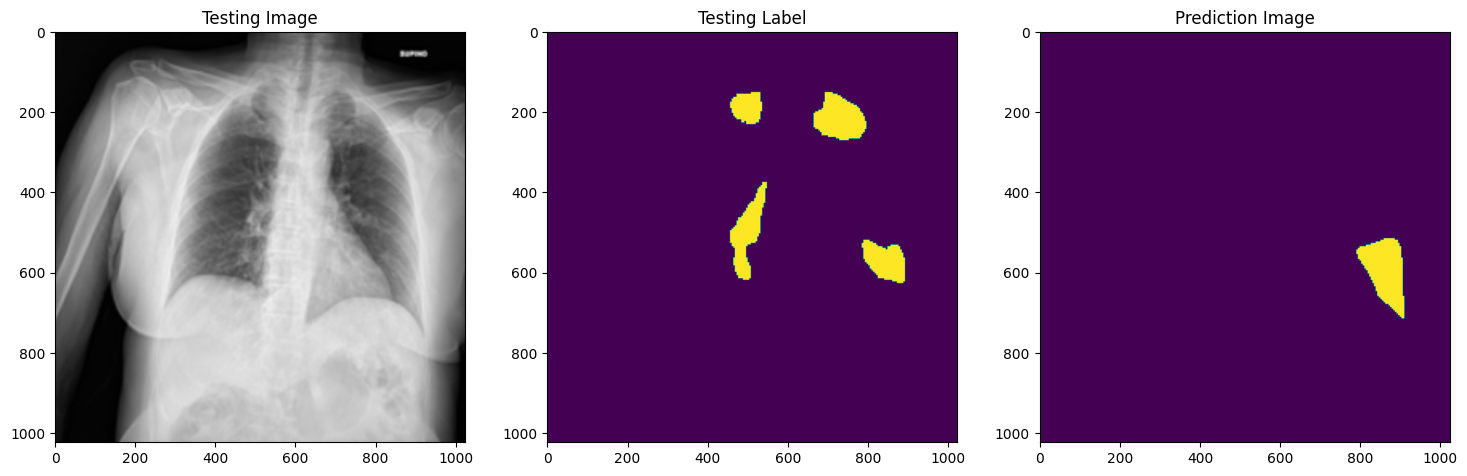

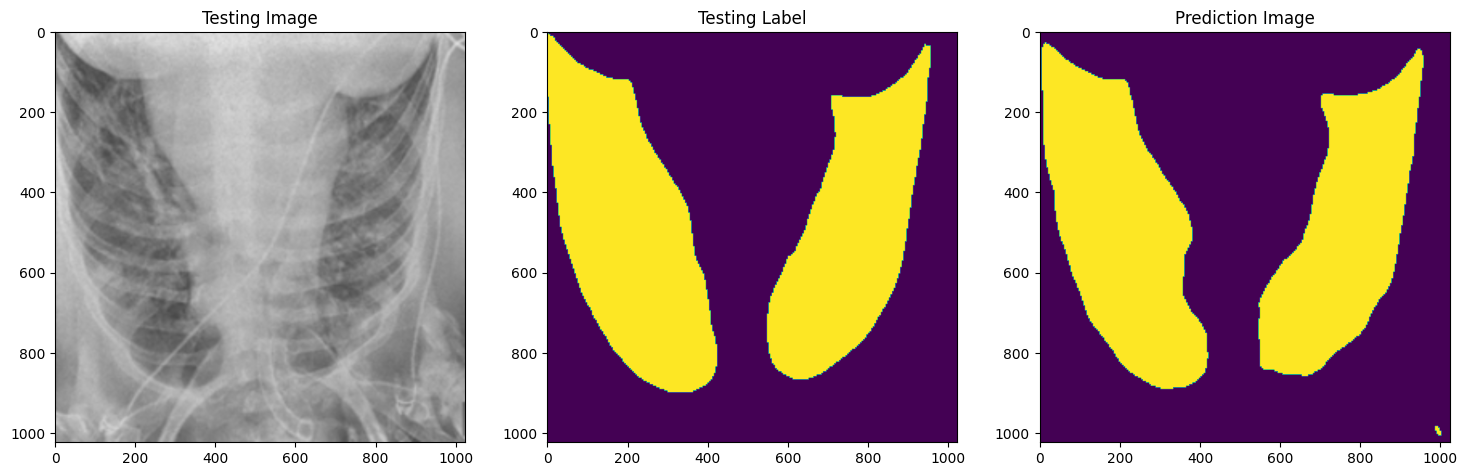

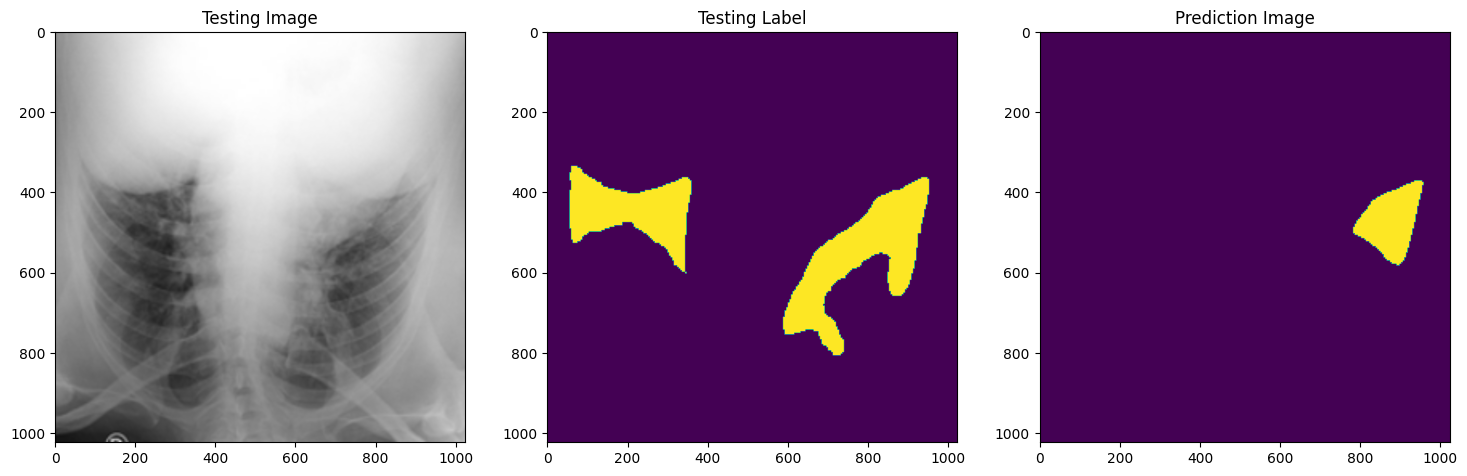

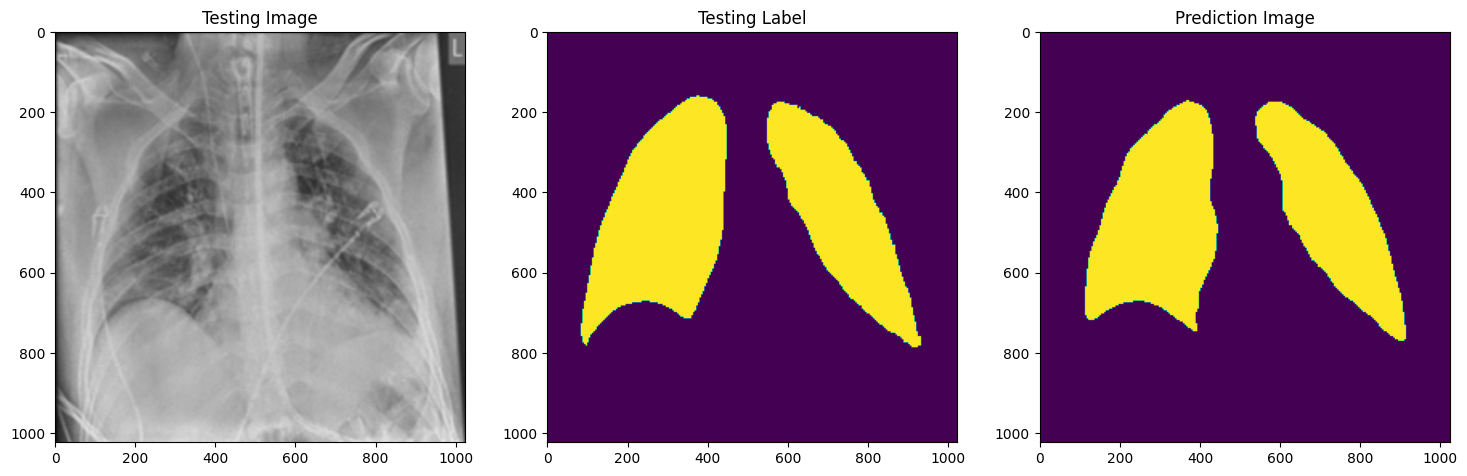

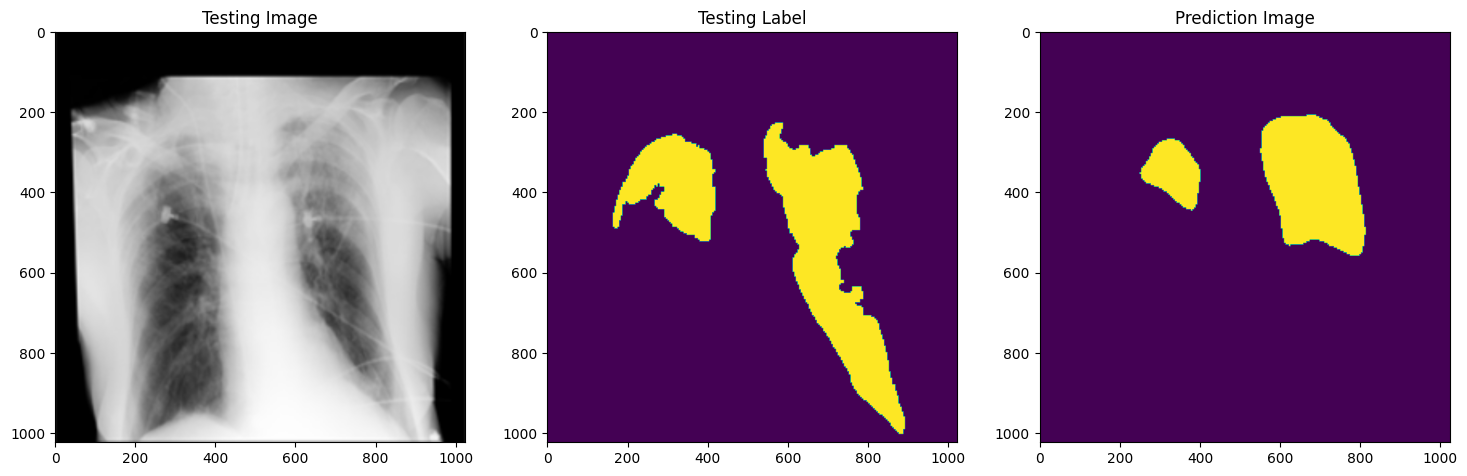

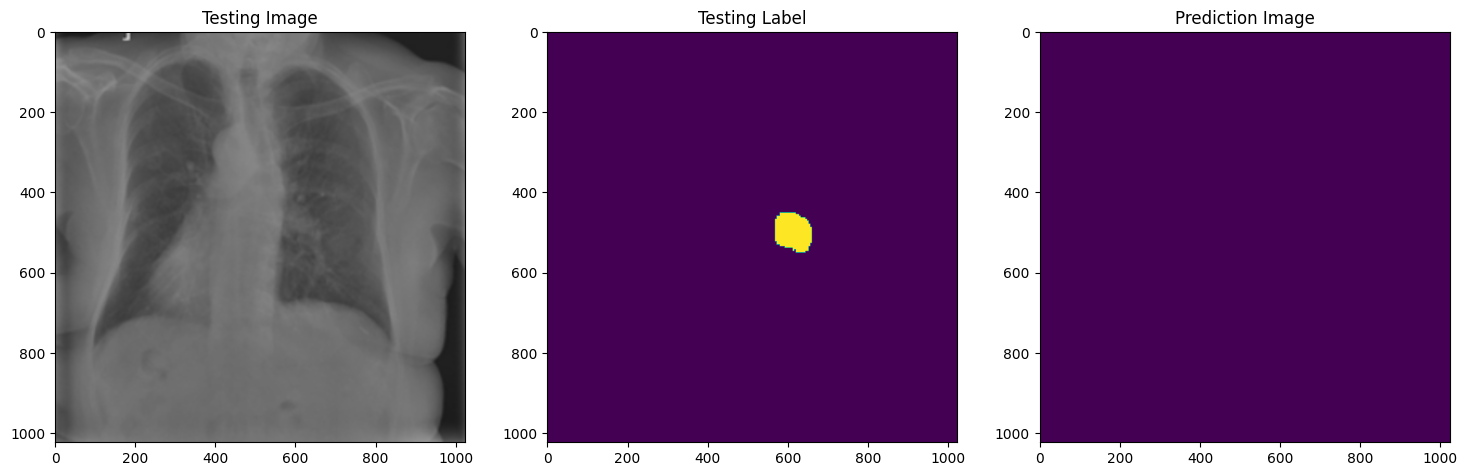

In [ ]:
import matplotlib.pyplot as plt
import cv2

target_shape = (1024, 1024)

for img_num in range(test_image_batch.shape[0]):
    resized_test_image = cv2.resize(test_image_batch[img_num], target_shape[::-1])

    resized_test_label = cv2.resize(test_mask_batch_argmax[img_num].astype(float), target_shape[::-1], interpolation=cv2.INTER_NEAREST)

    resized_test_pred = cv2.resize(test_pred_batch_argmax[img_num].astype(float), target_shape[::-1], interpolation=cv2.INTER_NEAREST)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].set_title('Testing Image')
    axs[0].imshow(resized_test_image)

    axs[1].set_title('Testing Label')
    axs[1].imshow(resized_test_label)

    axs[2].set_title('Prediction Image')
    axs[2].imshow(resized_test_pred)

    plt.show()
